# Flower Classification

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import cv2
import random
from keras.applications import EfficientNetV2B0
from keras.applications.efficientnet_v2 import preprocess_input

tf.config.optimizer.set_jit(True)

2024-03-22 14:03:20.437306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 14:03:20.437330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 14:03:20.438190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Visualization

As seen from the distribution of the classes, our dataset is heavily imbalanced.
Images in the BASE_DIR, are in the format of image_0****.jpg, and labels are indexed according to the image number. One thing to be careful about is that images' count starts from 1 and as it is the case with their labels

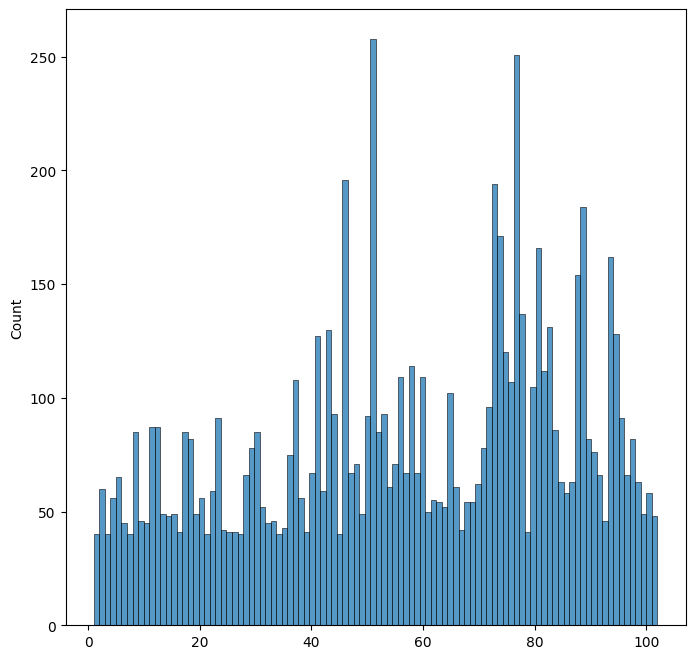

In [2]:
VALIDATION_SPLIT = 0.2
BASE_DIR = './102flowers/jpg'
img_dirs = sorted(os.listdir(BASE_DIR))

labels = loadmat('./imagelabels.mat')['labels']
labels = np.squeeze(labels)

fig = plt.figure(figsize=(8, 8))
sns.histplot(labels, bins=102);

If we are to split let's say 20% of the data completely randomly to be in our validation set, we might take too many from one class and take less from the other. It is a better idea to take 20% off of each class rather than the whole dataset, so to be fair according to each class's population.

In [3]:
counts = {}
for lbl in labels:
    counts[lbl] = counts.get(lbl, 0) + 1

def get_train_validation_split(img_dirs, labels, counts):
    validation_split = {}
    for k, v in counts.items():
        validation_split[k] = int(v * VALIDATION_SPLIT)

    img_lbl = list(zip(img_dirs, labels))
    random.shuffle(img_lbl)
    training = []
    validation = []
    for img, lbl in img_lbl:
        if validation_split[lbl] == 0: 
            training.append([img, lbl])
            continue
        validation.append([img, lbl])
        validation_split[lbl] -= 1

    return training, validation


training_data, validation_data = get_train_validation_split(img_dirs, labels, counts)
print(f'Training data has {len(training_data):>4} samples')
print(f'Validation data has {len(validation_data):>4} samples')

Training data has 6587 samples
Validation data has 1602 samples


## Create a dataset

In [4]:
SHUFFLE_BUFFER = 1000
IMAGE_SIZE = 224
LABELS = tf.convert_to_tensor(labels)
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE


augment_layer = keras.Sequential([
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomTranslation(0.15, 0.15)
])


def get_images(path):
    file = tf.io.read_file(tf.strings.join([BASE_DIR, path], separator='/'))
    image = tf.image.decode_jpeg(file)
    return image


def normalize(image):
    return preprocess_input(image)


def get_labels(path):
    file_name = tf.strings.split(path, sep='.')[0]
    num = tf.strings.split(file_name, sep='_')[-1]
    num = tf.strings.to_number(num, out_type=tf.int32)
    return LABELS[num - 1] - 1


def get_image_labels(path):
    label = get_labels(path)
    image = get_images(path)
    image = tf.image.resize(image, size=(IMAGE_SIZE, IMAGE_SIZE))
    label = tf.cast(label, tf.int32)
    return image, label


def get_image_labels_for_train(path):
    label = get_labels(path)
    image = get_images(path)
    label = tf.cast(label, tf.int32)
    return image, label


def augment(image):
    image = tf.image.random_contrast(image, 0.6, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.3)
    image = tf.image.random_saturation(image, 0.6, 1.2)
    image = tf.clip_by_value(image, 0, 255)
    return image


def get_training_dataset(image, label):
    image = tf.image.resize(image, size=(IMAGE_SIZE, IMAGE_SIZE))
    image = augment(image)
    image = augment_layer(image)
    image = normalize(image)
    label = tf.one_hot(label, 102)
    return image, label


def get_validation_dataset(image, label):
    image = tf.cast(image, dtype='float32')
    image = normalize(image)
    label = tf.one_hot(label, 102)
    return image, label


train_ds = tf.data.Dataset.from_tensor_slices([x for x, y in training_data])
train_ds = train_ds.map(get_image_labels_for_train, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.map(get_training_dataset, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(SHUFFLE_BUFFER)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices([x for x, y in validation_data])
valid_ds = valid_ds.map(get_image_labels, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(get_validation_dataset, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.cache()
valid_ds = valid_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

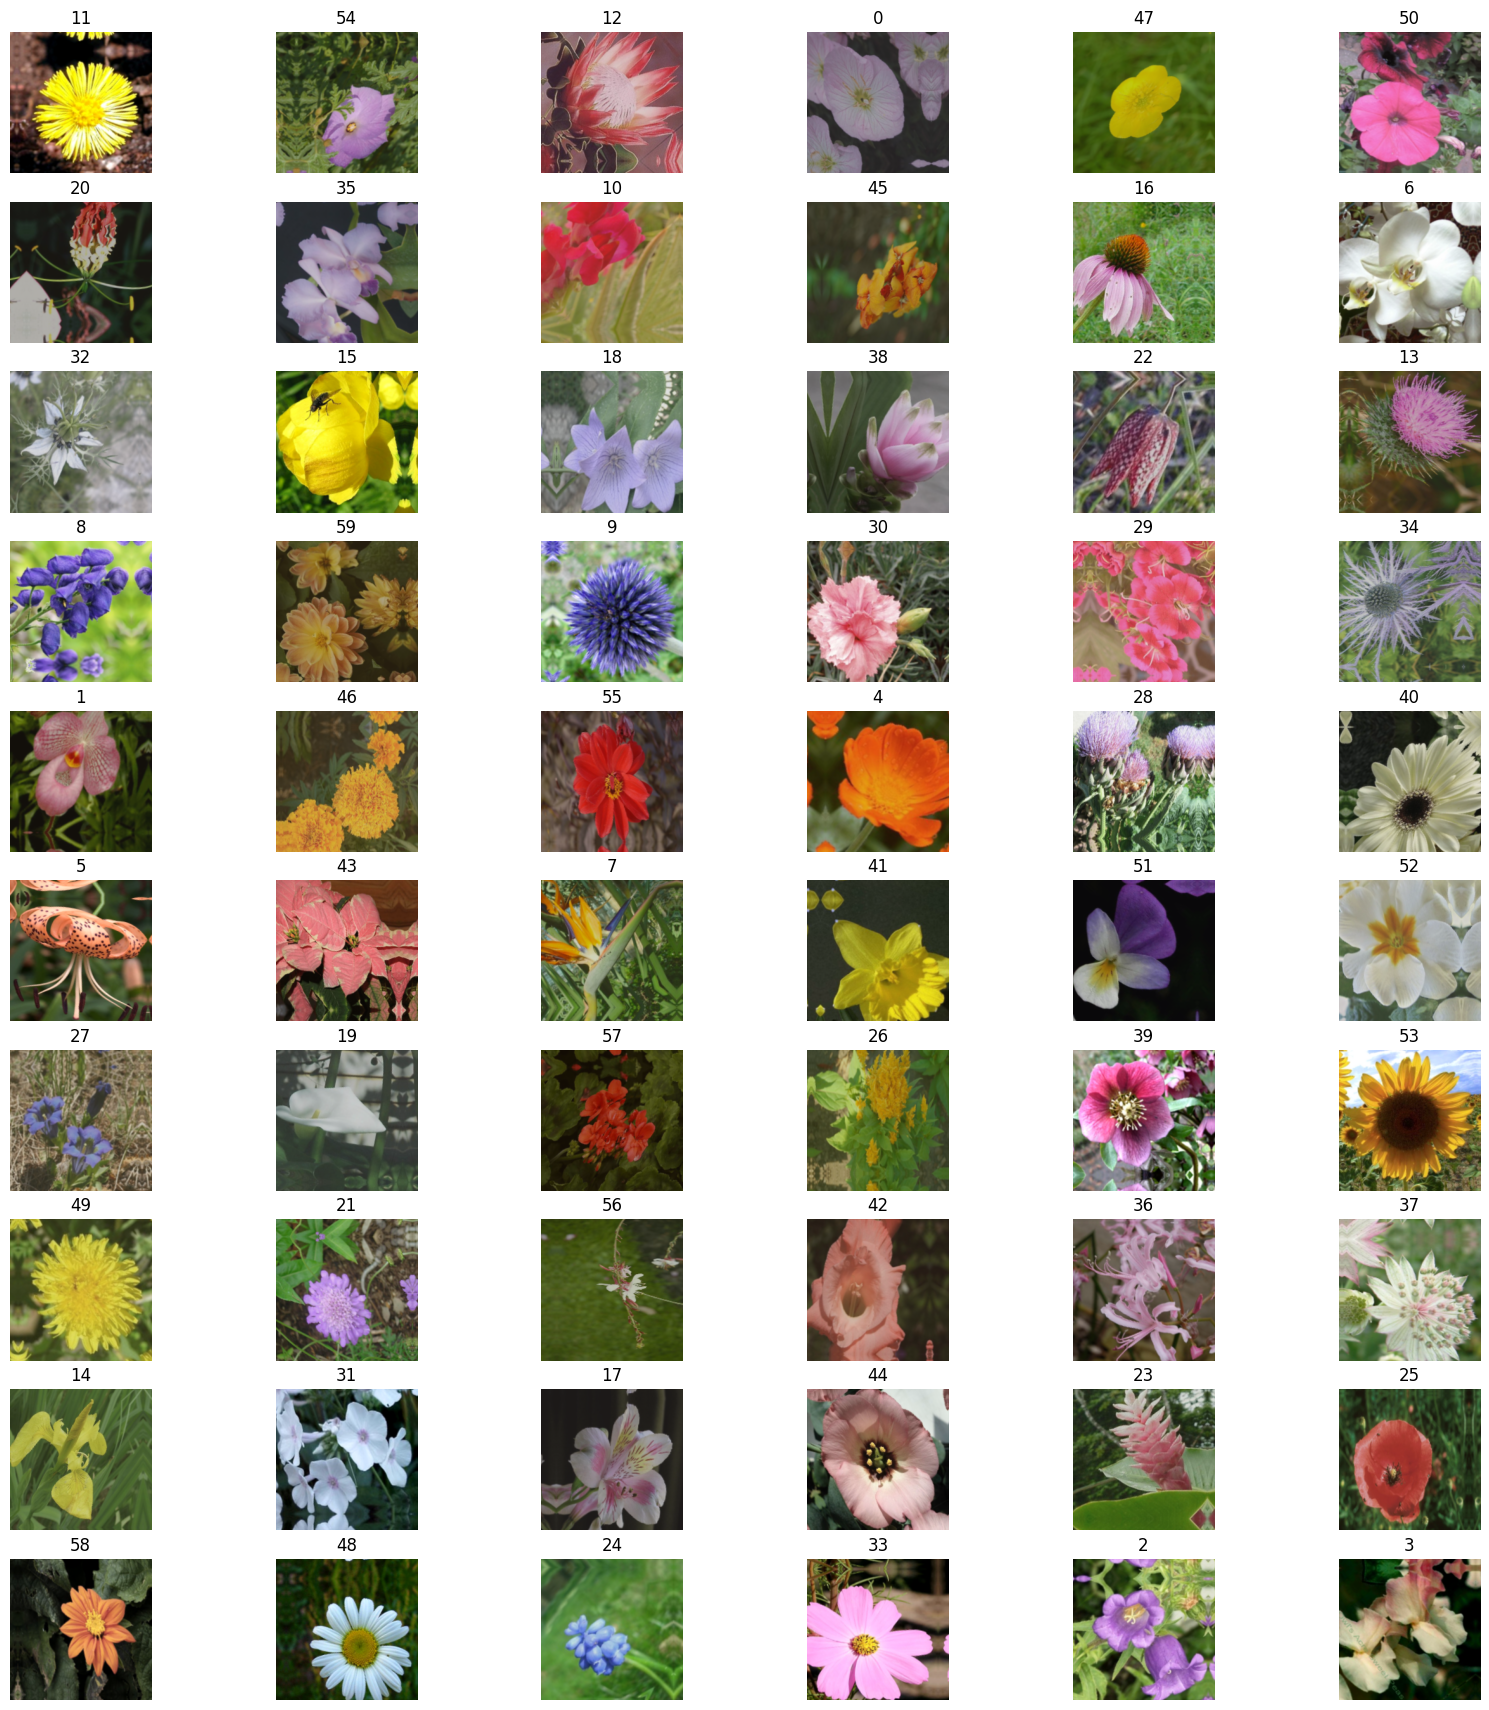

In [5]:
visualize_ds = tf.data.Dataset.from_tensor_slices([x for x, y in training_data])
visualize_ds = visualize_ds.map(get_image_labels_for_train, num_parallel_calls=AUTOTUNE)
visualize_ds = visualize_ds.map(lambda img, lbl: (tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE)), lbl), num_parallel_calls=AUTOTUNE)
visualize_ds = visualize_ds.map(lambda img, lbl: (augment(img), lbl), num_parallel_calls=AUTOTUNE)
visualize_ds = visualize_ds.map(lambda img, lbl: (tf.clip_by_value(img, 0, 255), lbl), num_parallel_calls=AUTOTUNE)
visualize_ds = visualize_ds.map(lambda img, lbl: (augment_layer(img), lbl), num_parallel_calls=AUTOTUNE)
visualize_ds = visualize_ds.shuffle(SHUFFLE_BUFFER)
visualize_ds = visualize_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
visualize_ds = visualize_ds.prefetch(AUTOTUNE)

fig = plt.figure(figsize=(20, 12))
plt_i = 0
LABEL = [1 if i < 60 else 0 for i in range(102)]
for img, lbl in visualize_ds:
    for i in range(img.shape[0]):
        if plt_i >= 60: break
        label = lbl[i]
        if label.ndim == 1:
            label = np.argmax(label)
        if LABEL[label] == 0: continue
        ax = plt.subplot(10, 6, plt_i + 1)
        ax.imshow(img[i] / 255.0)
        ax.axis('off')
        ax.set_title(f'{label}')
        plt_i += 1
        LABEL[label] -= 1
fig.subplots_adjust(top=1.5)

In [6]:
img = next(iter(train_ds.take(10)))[0]
print('Training')
print(f'\nMAX: {np.max(img)} \nMIN: {np.min(img)} \nMEAN: {np.mean(img)} \nSTD: {np.std(img)}')

img = next(iter(valid_ds.take(10)))[0]
print('\nValidation')
print(f'\nMAX: {np.max(img)} \nMIN: {np.min(img)} \nMEAN: {np.mean(img)} \nSTD: {np.std(img)}')

Training

MAX: 255.0 
MIN: 0.0 
MEAN: 94.13593292236328 
STD: 64.27506256103516

Validation

MAX: 255.0 
MIN: 0.0 
MEAN: 93.06674194335938 
STD: 70.3861083984375


## Creating a model
Since we are up against a very small dataset with heavy imbalanced classes, we use transfer-learning.

In [7]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, Conv2D, Activation, MaxPooling2D
from keras.callbacks import LearningRateScheduler
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.optimizers import RMSprop, Adam
from keras.metrics import CategoricalAccuracy, Precision, Recall

In [8]:
base = EfficientNetV2B0(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base.trainable = False

One way to address the problem of imbalanced classses, is to use **Focal loss**. Focal loss applies a modulating term to the cross entropy loss in order to focus learning on hard misclassified examples. It is a dynamically scaled cross entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. Focal loss reduces the contribution of easy examples to the loss function, thereby giving more importance to difficult examples. Helps in dealing with noisy data: In real-world scenarios, the training data may be noisy, which can lead to misclassification.

In [9]:
def get_uncompiled_model(input_shape, base):
    inputs = Input(shape=input_shape)
    x = base(inputs)
    x = Conv2D(filters=1024, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.75)(x)
    x = Dense(units=102)(x)
    return keras.Model(inputs=inputs, outputs=x)

model = get_uncompiled_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), base=base)
model.compile(
    loss = CategoricalFocalCrossentropy(from_logits=True),
    optimizer=Adam(),
    metrics=[CategoricalAccuracy(), Precision(), Recall()]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 1024)        11797504  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (  (None, 1024)              0     

Mostly Focal loss is used for hard examples and noisy datasets and is not intended to address the problem of imbalanced datasets. One of the effective ways to address the problem is to add more weights to classes with less population and less to the classes that have more population compared to the others

In [10]:
weights = {}
total_sum = len(training_data)
for _, lbl in training_data:
    lbl -= 1
    weights[lbl] = weights.get(lbl, 0) + 1

for k, v in weights.items():
    weights[k] = total_sum / (v * 102) 

In [11]:
def get_lr_scheduler(initial_lr, weight=0.8):
    def lr_scheduler(epoch):
        return initial_lr * weight ** epoch
    return lr_scheduler

In [12]:
EPOCHS = 30
scheduler = LearningRateScheduler(get_lr_scheduler(1e-3, weight=0.95))

history1 = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds, 
    class_weight=weights,
    callbacks=[scheduler]
)

Epoch 1/30


2024-03-22 14:03:43.132591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711130628.657997  108390 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711130641.297724  108390 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - ETA: 0s - loss: 0.5359 - categorical_accuracy: 0.4312 - precision: 0.1407 - recall: 0.5807

W0000 00:00:1711130660.646653  108382 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - 46s 218ms/step - loss: 0.5359 - categorical_accuracy: 0.4312 - precision: 0.1407 - recall: 0.5807 - val_loss: 0.0888 - val_categorical_accuracy: 0.8521 - val_precision: 0.6397 - val_recall: 0.7990 - lr: 0.0010
Epoch 2/30
103/103 [==============================] - 33s 311ms/step - loss: 0.2106 - categorical_accuracy: 0.6879 - precision: 0.4306 - recall: 0.7402 - val_loss: 0.0524 - val_categorical_accuracy: 0.9020 - val_precision: 0.6846 - val_recall: 0.8577 - lr: 9.5000e-04
Epoch 3/30


W0000 00:00:1711130696.778485  108376 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/103 [==============================] - 12s 107ms/step - loss: 0.1493 - categorical_accuracy: 0.7539 - precision: 0.4993 - recall: 0.7718 - val_loss: 0.0400 - val_categorical_accuracy: 0.9245 - val_precision: 0.7152 - val_recall: 0.8808 - lr: 9.0250e-04
Epoch 4/30
103/103 [==============================] - 12s 107ms/step - loss: 0.1196 - categorical_accuracy: 0.7954 - precision: 0.5368 - recall: 0.7996 - val_loss: 0.0389 - val_categorical_accuracy: 0.9320 - val_precision: 0.7232 - val_recall: 0.8727 - lr: 8.5737e-04
Epoch 5/30
103/103 [==============================] - 12s 107ms/step - loss: 0.1018 - categorical_accuracy: 0.8177 - precision: 0.5603 - recall: 0.8045 - val_loss: 0.0320 - val_categorical_accuracy: 0.9388 - val_precision: 0.7223 - val_recall: 0.8964 - lr: 8.1451e-04
Epoch 6/30
103/103 [==============================] - 12s 107ms/step - loss: 0.0872 - categorical_accuracy: 0.8371 - precision: 0.5656 - recall: 0.8271 - val_loss: 0.0302 - val_categorical_accuracy: 0.9438 -

### Fine Tuning
Following transfer learning, we unfreeze some of the layers from the base model to make them consistant with the layers newly trained in transfer-learning stage. Fine turning requires us to update the parameters carefully with small learning rate, otherwise not only layers in the base model do not learn anything but aggressive change will make the layers forget what they have learned

In [13]:
FREEZE_UP_TO = 149

for i, l in enumerate(base.layers):
    print(f'{i:>3}', f'{l.name:>40}', l.output_shape)

model.trainable = True

for i in range(FREEZE_UP_TO):
    model.layers[1].layers[i].trainable = False

model.summary()

  0                                  input_1 [(None, 224, 224, 3)]
  1                                rescaling (None, 224, 224, 3)
  2                            normalization (None, 224, 224, 3)
  3                                stem_conv (None, 112, 112, 32)
  4                                  stem_bn (None, 112, 112, 32)
  5                          stem_activation (None, 112, 112, 32)
  6                     block1a_project_conv (None, 112, 112, 16)
  7                       block1a_project_bn (None, 112, 112, 16)
  8               block1a_project_activation (None, 112, 112, 16)
  9                      block2a_expand_conv (None, 56, 56, 64)
 10                        block2a_expand_bn (None, 56, 56, 64)
 11                block2a_expand_activation (None, 56, 56, 64)
 12                     block2a_project_conv (None, 56, 56, 32)
 13                       block2a_project_bn (None, 56, 56, 32)
 14                      block2b_expand_conv (None, 56, 56, 128)
 15                   

In [14]:
FINE_TUNE_EPOCHS = 60
scheduler = LearningRateScheduler(get_lr_scheduler(4e-4, 0.96))
history2 = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=valid_ds, 
    class_weight=weights,
    callbacks=[scheduler]
)

Epoch 1/60
103/103 [==============================] - 12s 110ms/step - loss: 0.0261 - categorical_accuracy: 0.9326 - precision: 0.6723 - recall: 0.9009 - val_loss: 0.0180 - val_categorical_accuracy: 0.9644 - val_precision: 0.7807 - val_recall: 0.9220 - lr: 4.0000e-04
Epoch 2/60
103/103 [==============================] - 12s 110ms/step - loss: 0.0269 - categorical_accuracy: 0.9371 - precision: 0.6924 - recall: 0.8899 - val_loss: 0.0174 - val_categorical_accuracy: 0.9682 - val_precision: 0.7860 - val_recall: 0.9263 - lr: 3.8400e-04
Epoch 3/60
103/103 [==============================] - 12s 109ms/step - loss: 0.0235 - categorical_accuracy: 0.9435 - precision: 0.6892 - recall: 0.8960 - val_loss: 0.0192 - val_categorical_accuracy: 0.9625 - val_precision: 0.7867 - val_recall: 0.9189 - lr: 3.6864e-04
Epoch 4/60
103/103 [==============================] - 12s 109ms/step - loss: 0.0237 - categorical_accuracy: 0.9388 - precision: 0.6937 - recall: 0.8855 - val_loss: 0.0187 - val_categorical_accurac

### Evaluation

In [15]:
from sklearn.metrics import classification_report

In [16]:
def plot(history, key, ax):
    training_key = key
    validation_key = 'val_' + key
    ax.plot(history.epoch, history.history[training_key], label='train_'+key)
    ax.plot(history.epoch, history.history[validation_key], label='valid_'+key)
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid(c='#ccc')
    ax.legend()
    return ax

In [17]:
history = history1
total_epochs = len(history1.epoch) + len(history2.epoch)
history.epoch = list(range(total_epochs))
for key in history.history.keys():
    history.history[key] = history.history[key] + history2.history[key]

Below we can see, fine tuning actually made progress both on precision and recall

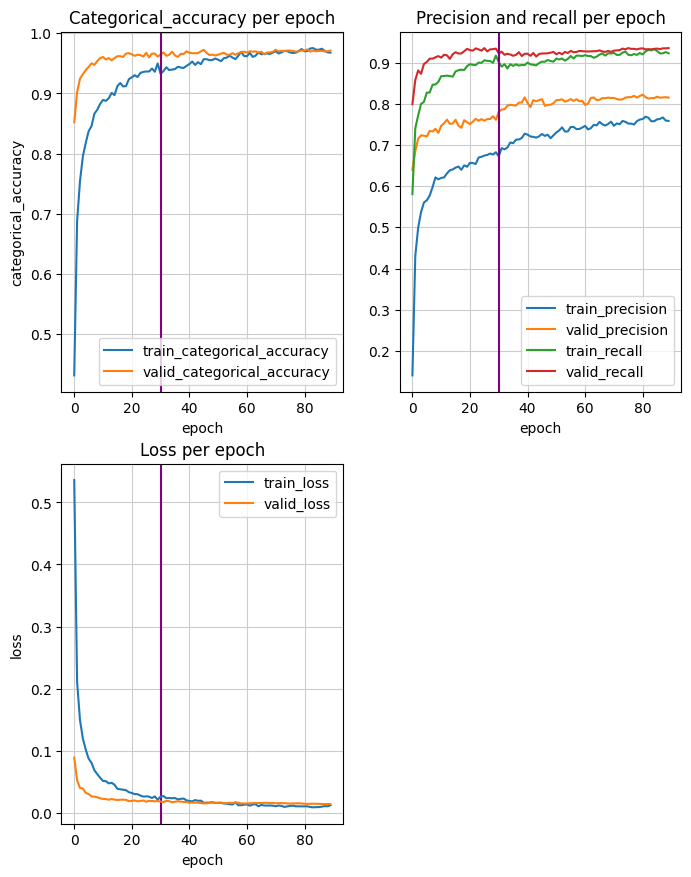

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 2, 1)
ax = plot(history, 'categorical_accuracy', ax)
ax.axvline(EPOCHS, c='purple')
ax = plt.subplot(2, 2, 2)
ax = plot(history, 'precision', ax)
ax = plot(history, 'recall', ax)
ax.axvline(EPOCHS, c='purple')
ax.set_title('Precision and recall per epoch')
ax.set_ylabel('');
ax = plt.subplot(2, 2, 3);
ax.axvline(EPOCHS, c='purple')
ax = plot(history, 'loss', ax)
fig.subplots_adjust(top=1.1)

**Since we have imbalanced classes, confusion matrix cannot show in heatmap what classes are classified better unless their ratio are illustrated via heapmap as seen below**

W0000 00:00:1711131767.038854  108378 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


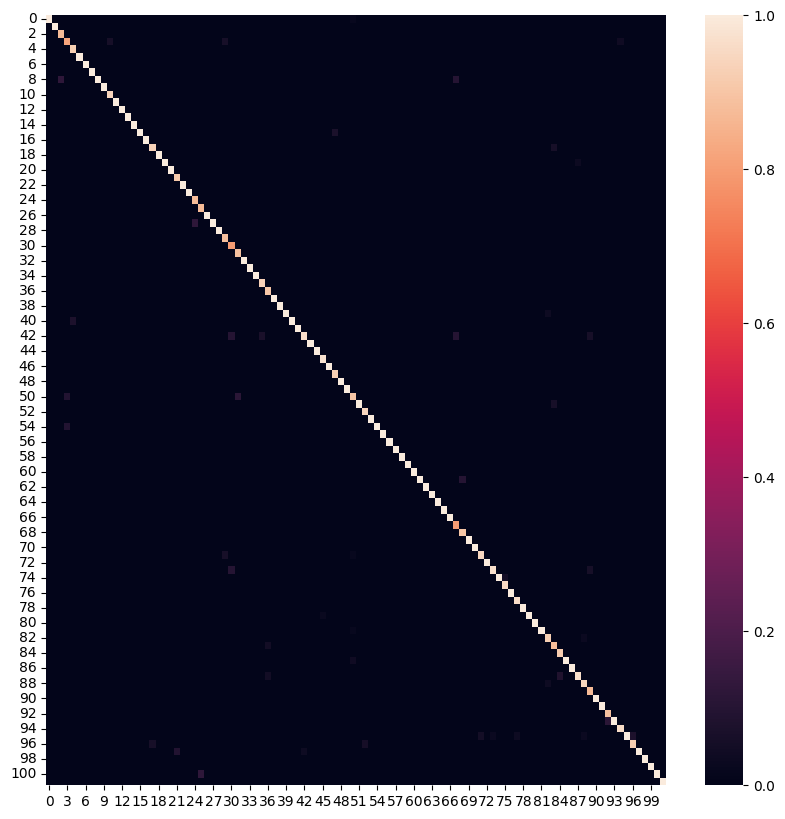

In [19]:
y_pred = tf.argmax(model.predict(valid_ds, verbose=0), axis=-1)
y_true = []
for _, lbl in valid_ds:
    for l in lbl: y_true.append(np.argmax(l))


valid_counts = {}
for _, lbl in validation_data:
    lbl -= 1
    valid_counts[lbl] = valid_counts.get(lbl, 0) + 1

conf_matrix = np.zeros((102, 102), dtype=np.float32)
for i in range(len(y_true)):
    true = y_true[i]
    pred = y_pred[i]
    conf_matrix[pred, true] += 1 / valid_counts[true]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix);

### Classification Report

In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00        12
           2       1.00      0.88      0.93         8
           3       0.75      0.82      0.78        11
           4       1.00      0.92      0.96        13
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        17
           8       0.82      1.00      0.90         9
           9       1.00      1.00      1.00         9
          10       1.00      0.94      0.97        17
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         9
          15       0.89      1.00      0.94         8
          16       1.00      1.00      1.00        17
          17       0.94    

In [21]:
model.save('./saves/tf/02_efficient_netB0_97.tf')
model.save('./saves/keras/02_efficient_netB0_97.keras')

INFO:tensorflow:Assets written to: ./saves/tf/02_efficient_netB0_97.tf/assets


INFO:tensorflow:Assets written to: ./saves/tf/02_efficient_netB0_97.tf/assets
